In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import itertools
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from IPython import display
import seaborn as sns
import gym

In [2]:
env = gym.make("BipedalWalker-v2")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/montaser/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [51]:
n_eps= 10
t_steps = 500
gamma = 0.99

for ep in range (n_eps):
    R=0
    s = env.reset()
    rewards=[]
    for t in range (t_steps):
        action = env.action_space.sample()
        s, r, done, _ = env.step(action)
        if done: break
        rewards.append(r)
    for i in range (len(rewards)):
        R += rewards[i]*(gamma**i)
    print("ep={} , t={} , reward= {:.3f}".format(ep, t, R))

ep=0 , t=62 , reward= -0.429
ep=1 , t=152 , reward= -13.495
ep=2 , t=499 , reward= -7.855
ep=3 , t=45 , reward= -9.783
ep=4 , t=499 , reward= -6.424
ep=5 , t=113 , reward= -4.374
ep=6 , t=72 , reward= -0.452
ep=7 , t=84 , reward= -10.063
ep=8 , t=66 , reward= -2.247
ep=9 , t=128 , reward= -6.438


In [3]:
def plot_kmeans (n, n_clusters = 3):
    a = (np.arange(-10,11, 4)/10).tolist()
    m = torch.load("new_Walker2d_model_n={}".format(n))
    inputs = torch.tensor([list(i) for i in itertools.product(a, repeat=4*n)], dtype=torch.float)
    embeddings =  m[:8](inputs).detach().numpy()
    pca = PCA(n_components=2, svd_solver='full' ).fit_transform(embeddings)
    kmean = KMeans(n_clusters= n_clusters).fit_predict(embeddings)
    
    data = pd.DataFrame(pca)
    data.columns = ['x1', 'x2']
    data['Clusters'] = pd.Series(kmean, index=data.index)
    index = []
    means = []
    std = []
#     for i in range(n):
#         index.append(list(np.where(kmean==i)[0]))
    for i in range (n_clusters):
        index.append(list(np.where(kmean==i)[0]))
        
        means.append(np.array(torch.mean(inputs[index[i]],0)).tolist())
        std.append(np.array(torch.std(inputs[index[i]],0)).tolist())
        
        w = np.round(means[-1],2).tolist()
        c = ",".join(str(x) for x in w)
        data.Clusters.replace([i], [c], inplace=True)
    plot = sns.lmplot(data=data, x='x1', y='x2', hue='Clusters', fit_reg=False, legend=True, legend_out=True)
#     plot.savefig("fig/Walker2d_Clusters={}_n={}".format(n_clusters,n), dpi=600)
    return inputs , means , std

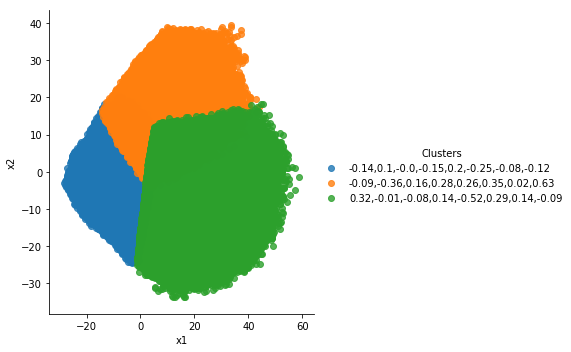

In [5]:
_ , means, std  = plot_kmeans(2,3)

In [8]:
def expolare_action_space (cluster_number, means, std):
    action = np.zeros(4)
    for i in range (4):
        action[i] = np.random.normal(means[cluster_number][i], std[cluster_number][i], 1)
    return action

In [43]:
expolare_action_space (0, means, std)

array([-0.38013291,  0.09461362, -1.04496296, -0.58242397])

In [22]:
np.random.normal(means[0][0], std[0][0], 1)

array([-0.45020117])

# Model

In [8]:
model = nn.Sequential(
    
    nn.Linear(140, 90),
    nn.ReLU(),
    
    nn.Linear(90, 100),
    nn.ReLU(),
    
    nn.Linear(100, 120),
    nn.ReLU(),
    
    nn.Linear(120, 80),
    nn.ReLU(),
    
    nn.Linear(80, 60),
    nn.ReLU(),
    
    nn.Linear(60, 40),
    nn.ReLU(),
    
    nn.Linear(40, 20),
    nn.ReLU(),
    
    nn.Linear(20, 15),
    nn.ReLU(),
    
    nn.Linear(15, 10),
    nn.ReLU(),
    
    nn.Linear(10, 4),
)

In [3]:
# states_walker2d= np.load("states_TRPO_walker2d_6.npy")[4000:]
# actions_walker2d= np.load("actions_TRPO_walker2d_6.npy")[4000:]

In [4]:
# new_states = np.zeros((states_walker2d.shape[0],499, 24))
# new_actions = np.zeros((actions_walker2d.shape[0],499, 4))

# for i in range (states_walker2d.shape[0]):
#     new_states[i] = np.delete(states_walker2d[i], 0, axis=0)
#     new_actions[i] = np.delete(actions_walker2d[i], 499, axis=0)

In [6]:
# new_states = torch.tensor(new_states, dtype=torch.float)
# new_actions = torch.tensor(new_actions, dtype=torch.float)
# print("new_states.shape",new_states.shape)
# print("new_actions.shape",new_actions.shape)

new_states.shape torch.Size([70000, 499, 24])
new_actions.shape torch.Size([70000, 499, 4])


In [2]:
states_walker2d= np.load("states_TRPO_walker2d_6.npy")[:4000]
actions_walker2d= np.load("actions_TRPO_walker2d_6.npy")[:4000]
states_walker2d = torch.tensor(states_walker2d, dtype=torch.float)
actions_walker2d = torch.tensor(actions_walker2d, dtype=torch.float)
print("states_walker2d.shape",states_walker2d.shape)
print("actions_walker2d.shape",actions_walker2d.shape)

states_walker2d.shape torch.Size([4000, 500, 24])
actions_walker2d.shape torch.Size([4000, 500, 4])


# preprocessing

In [3]:
############ for expert agent ############
def pre_processing (states, actions, n=3):
    ep, t, state_size = states.shape
    _,_, action_space = actions.shape
    output = torch.zeros ((ep*(t-n-1), n*(state_size+action_space)+action_space))
    index=0
    indices = []
    for i in range (ep):
        for j in range (t-n-1):
            output[index, : state_size*n] = states[i, j+1:j+n+1].view(-1)
            output[index, state_size*n: ]  = actions[i, j:j+n+1].view(-1)
            index+=1
    for i in range (output.shape[0]):
        if (output[i,n*state_size:] == -1*torch.ones((n+1)*action_space)).all() or (output[i,:state_size] == -1*torch.ones(state_size)).all():
            indices.append(i)
    cleaned_data = torch.tensor(np.delete(np.array(output), indices, axis=0))
    return cleaned_data
new_data  = pre_processing(states_walker2d, actions_walker2d, 5)
print("new_data.shape",new_data.shape)

new_data.shape torch.Size([1946515, 144])


In [4]:
np.random.shuffle(np.array(new_data))
new_data = torch.tensor(new_data, dtype=torch.float)

/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [5]:
# def pre_processing (array, n=3):
#     ep, t, _= array.shape
#     output = torch.zeros ((ep*(t-n), 4*(n+1)))
#     index=0
#     indices = []
#     for i in range (ep):
#         for j in range (t-n):
#             output[index] = array[i, j:j+n+1].view(-1)
#             index+=1
#     for i in range (output.shape[0]):
#         if (output[i] == -5*torch.ones(4*(n+1))).any():
#             indices.append(i)
#     cleaned_data = torch.tensor(np.delete(np.array(output), indices, axis=0))
#     return cleaned_data
# new_data  = pre_processing(actions_walker2d, 5)
# print("new_data.shape",new_data.shape)

In [6]:
n_samples = int(0.8*new_data.shape[0])

In [7]:
training_set = new_data[:n_samples]
testing_set = new_data[n_samples:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

training_set torch.Size([1557212, 144])
testing_set torch.Size([389303, 144])


# Train

In [9]:
losses = []
test_loss = []
n_itrations=150
batch_size=256
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for itr in range (n_itrations):
    if itr%50 == 0:
        torch.save(model, "Walker2d_model_with_states_n=5")        
    total_loss = 0
    total_acc = []
    for b in range (0, training_set.shape[0], batch_size):
        y = torch.tensor(training_set[b:b+batch_size, 140:], dtype=torch.float)
        y_pred = model(training_set[b:b+batch_size, :140])
#         print("y_pred", y_pred)
        loss = loss_function(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if itr > 0:
        losses.append(total_loss/training_set.shape[0])
    print("[EPOCH]: %i, [LOSS]: %.6f" % (itr, total_loss))
    display.clear_output(wait=True)
    test_loss.append(loss_function(model(testing_set[:,:140]), testing_set[:,140:]).item())

[EPOCH]: 149, [LOSS]: 54.757680


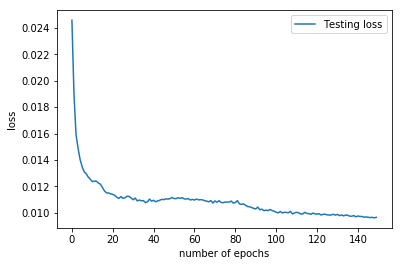

In [12]:
torch.save(model, "Walker2d_model_with_states_n=5")
# plt.plot(losses, label="Training loss")
plt.plot(test_loss, label="Testing loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# Test

In [13]:
y = torch.tensor(testing_set[:, 140:], dtype=torch.float)
y_pred = model(testing_set[:, :140])
# print("y",y)
# print("y_pred",y_pred)
print("loss",loss_function(y_pred, y).item())

/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


loss 0.009651079773902893


In [14]:
def find_all_combination (n): 
    a=[-1.0,-0.5,0.0, 1.0,2.0]
    return torch.tensor([list(i) for i in itertools.product(a, repeat=4*n)], dtype=torch.float)
# def find_all_combination (n):
#     combination = torch.zeros((n*n,4*n), dtype=torch.float)
#     return torch.tensor([list(i) for i in itertools.product([0.0, 1.0], repeat=4*n)])

In [15]:
# m = torch.load( "act2vec/models/Walker2d_model_n=5")
m= model
m[:8]

Sequential(
  (0): Linear(in_features=140, out_features=90, bias=True)
  (1): ReLU()
  (2): Linear(in_features=90, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=120, bias=True)
  (5): ReLU()
  (6): Linear(in_features=120, out_features=80, bias=True)
  (7): ReLU()
)

In [16]:
def prepare_inputs (n): 
    m = -np.ones((1, 28*n))
    o2 = -0.5*np.ones((1, 28*n ))
    z = np.zeros((1, 28*n ))
    o1 = 0.5*np.ones((1, 28*n ))
    o = np.ones((1, 28*n ))
    zom = torch.tensor(np.concatenate((m, o2, z, o1, o), 0), dtype=torch.float)
    return zom

In [17]:
# zom = find_all_combination (4)
zom = prepare_inputs (5)
zom.shape

torch.Size([5, 140])

In [18]:
vectors = model[:9](zom).detach().numpy()
vectors.shape

(5, 60)

In [19]:
pca = PCA(n_components=2, svd_solver='full' ).fit_transform(vectors)
pca.shape

(5, 2)

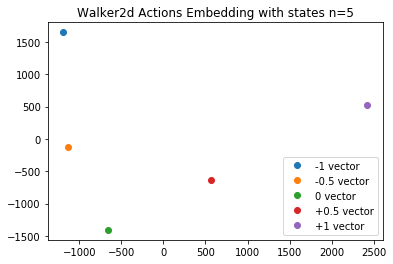

In [20]:
# for i in range (pca.shape[0]):
#     plt.plot(list(pca[i])[0], list(pca[i])[1] ,"o", label="{}".format(i))
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"o", label="-1 vector")
plt.plot(list(pca[1])[0], list(pca[1])[1] ,"o", label="-0.5 vector")
plt.plot(list(pca[2])[0], list(pca[2])[1] ,"o", label="0 vector")
plt.plot(list(pca[3])[0], list(pca[3])[1] ,"o", label="+0.5 vector")
plt.plot(list(pca[4])[0], list(pca[4])[1] ,"o", label="+1 vector")
plt.title("Walker2d Actions Embedding with states n=5")
plt.legend()
plt.savefig("fig/Walker2d_with_states_n=5", dpi=600)

Text(0.5, 1.0, 'Kmeans Act2Vec Walker2d n=4')

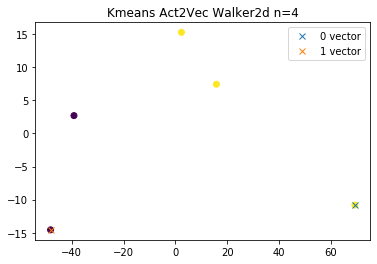

In [23]:
kmean = KMeans(n_clusters=2, random_state=0).fit_predict(pca)
plt.scatter(pca[:, 0], pca[:, 1], c=kmean)
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"x", label="0 vector")
# plt.plot(list(pca[200])[0], list(pca[200])[1] ,"x", label="0.5 vector")
plt.plot(list(pca[-1])[0], list(pca[-1])[1] ,"x", label="1 vector")
plt.legend()
plt.title("Kmeans Act2Vec Walker2d n=4")